# LTSFLinear

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Data

In [2]:
def generate_data(n=1000, T=12, n_anomalies=0, max_anomaly_size=5, n_normal_start=100):
    """
    Generate a simple 2D seasonal signal with optional injected anomalies.

    Parameters
    ----------
    n : int, default=1000
        Number of time steps.
    T : int, default=12
        Period of the sinusoidal/cosine components.
    n_anomalies : int, default=0
        Number of anomalous segments to inject.
    max_anomaly_size : int, default=5
        Maximum length (in time steps) of each anomalous segment.
    n_normal_start : int, default=100
        Earliest time index where anomalies may start (keeps prefix clean).

    Returns
    -------
    x : ndarray of shape (n, 2)
        The multivariate time series with two channels.
    y : ndarray of shape (n,)
        Binary labels indicating anomalies (1) and normal (0).
    """
    t = np.arange(n)
    t0 = np.random.randint(0, T)
    x1 = np.sin(2 * np.pi / T * (t + t0))
    x2 = np.cos(2 * np.pi / T * (t + t0))
    x = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1)
    y = np.zeros(n)

    for k in range(n_anomalies):
        i_start = np.random.randint(n_normal_start, n)
        i_end = i_start + np.random.randint(0, max_anomaly_size)
        level = np.random.rand()
        x[i_start:i_end] = level
        y[i_start:i_end] = 1

    return x, y

In [3]:
X_normal, y_normal = generate_data(n=500, n_anomalies=0)
X_attack, y_attack = generate_data(n=500, n_anomalies=10)

### Visualization

#### Normal Sample

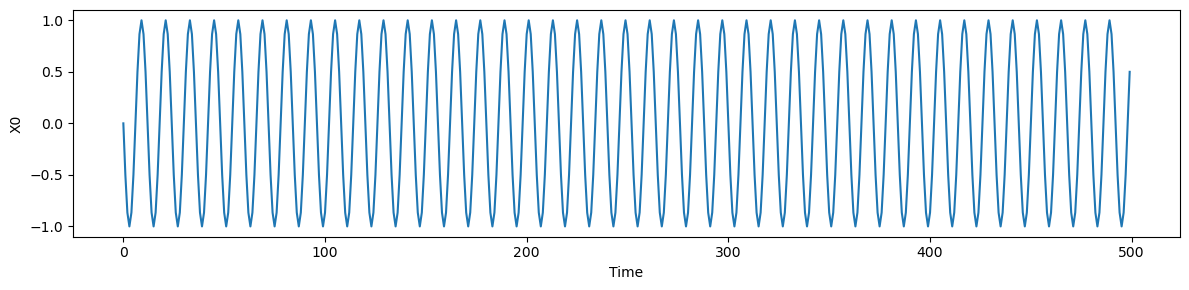

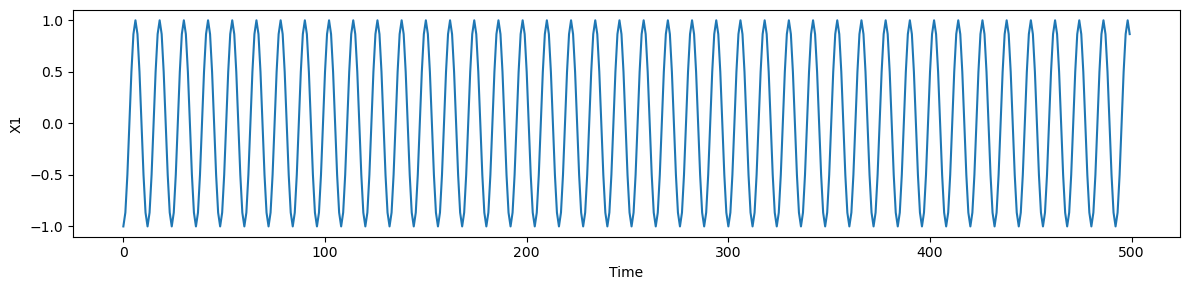

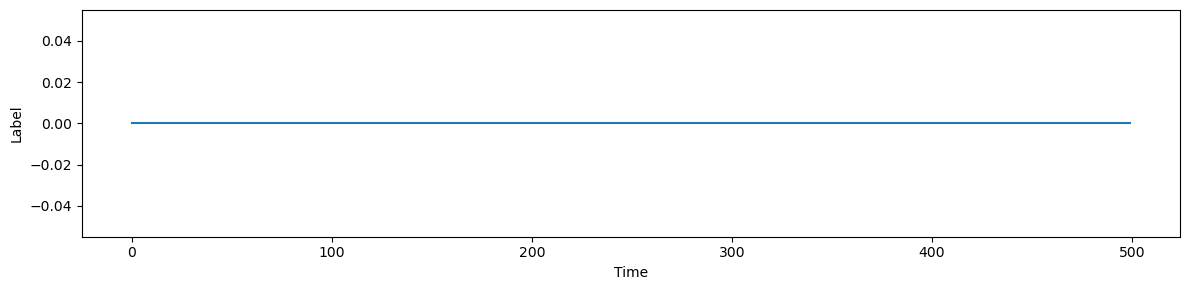

In [4]:
for i in range(X_normal.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_normal[:, i])
    plt.xlabel('Time')
    plt.ylabel('X'+str(i))
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_normal)
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

#### Sample with Attacks

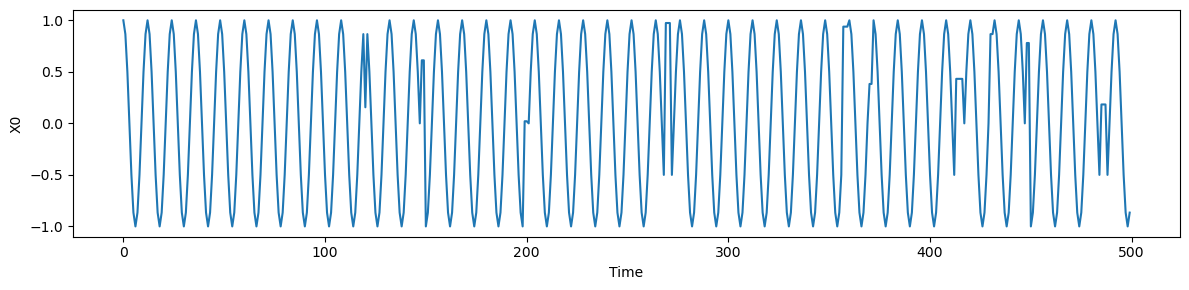

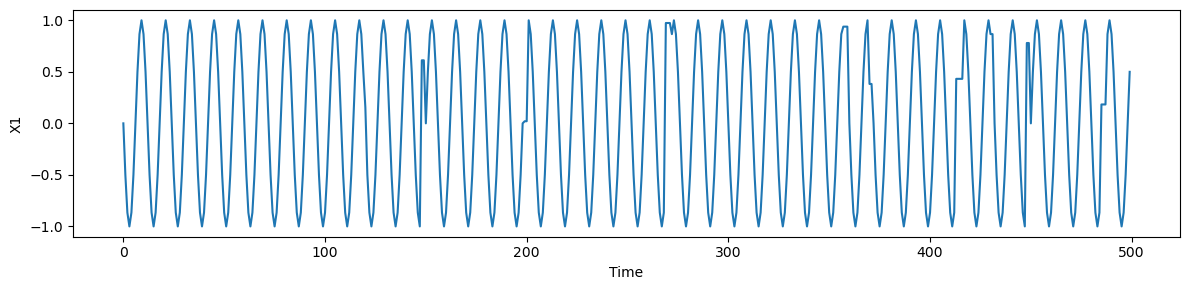

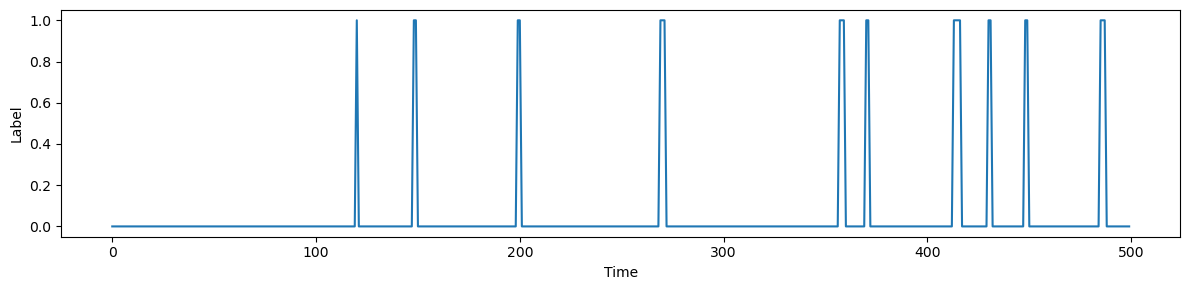

In [5]:
for i in range(X_attack.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_attack[:, i])
    plt.xlabel('Time')
    plt.ylabel('X'+str(i))
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_attack)
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

## Utilities

In [6]:
def standardize(X, mean=None, std=None):
    """
    Standardize features channel-wise.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input time series.
    mean : ndarray of shape (n_features,), optional
        Precomputed mean per channel. If None, computed from X.
    std : ndarray of shape (n_features,), optional
        Precomputed std per channel. If None, computed from X.

    Returns
    -------
    Xz : ndarray of shape (n_samples, n_features)
        Standardized series.
    mean : ndarray
        Mean used.
    std : ndarray
        Std used (with epsilon to avoid divide-by-zero).
    """
    if mean is None:
        mean = X.mean(axis=0)
    if std is None:
        std = X.std(axis=0)
    std = np.where(std < 1e-8, 1.0, std)
    return (X - mean) / std, mean, std

def build_windows(X, seq_len, pred_len, step=1):
    """
    Create (context, target) pairs via a sliding window.

    Parameters
    ----------
    X : ndarray of shape (n, c)
        Multivariate series.
    seq_len : int
        Context window length.
    pred_len : int
        Prediction horizon.
    step : int, default=1
        Stride between consecutive windows.

    Returns
    -------
    Xc : ndarray of shape (n_windows, seq_len, c)
        Context windows.
    Yt : ndarray of shape (n_windows, pred_len, c)
        Target windows (future labels to predict).
    """
    n, c = X.shape
    xs, ys = [], []
    for i in range(0, n - seq_len - pred_len + 1, step):
        xs.append(X[i:i + seq_len])
        ys.append(X[i + seq_len:i + seq_len + pred_len])
    return np.asarray(xs), np.asarray(ys)

In [7]:
# Standardize using only normal data stats
X_normal_z, mean_, std_ = standardize(X_normal)
X_attack_z, _, _ = standardize(X_attack, mean_, std_)

In [8]:
# Build training windows from NORMAL data

context_len = 40
prediction_len = 5
step = 5
batch_size = 64

Xc, Yt = build_windows(X_normal_z, context_len, prediction_len, step=step)
train_ds = TensorDataset(torch.tensor(Xc, dtype=torch.float32), torch.tensor(Yt, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

## Model

In [9]:
class LTSFLinear(nn.Module):
    """
    LTSF-Linear applies a single linear map across the temporal axis for each
    channel independently: for each channel, a Linear(seq_len -> pred_len)
    projects the past window into the future horizon.

    Parameters
    ----------
    seq_len : int
        Length of the context window.
    pred_len : int
        Forecast horizon length.
    channels : int
        Number of variables/channels in the multivariate series.
    """

    def __init__(self, seq_len: int, pred_len: int, channels: int, bias: bool = True):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.channels = channels
        # Linear applied on the last dim; we arrange input as (B, C, L)
        self.linear = nn.Linear(seq_len, pred_len, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x : torch.Tensor of shape (B, seq_len, C)
            Batch of context windows.

        Returns
        -------
        torch.Tensor of shape (B, pred_len, C)
            Forecasts for each channel.
        """
        # (B, L, C) -> (B, C, L)
        x = x.permute(0, 2, 1)
        # nn.Linear maps last-dim L -> pred_len, broadcasting over (B, C)
        y = self.linear(x)  # (B, C, pred_len)
        # Back to (B, pred_len, C)
        return y.permute(0, 2, 1)

In [10]:
channels = X_normal.shape[1]
device = "cpu"
model = LTSFLinear(seq_len=context_len, pred_len=prediction_len, channels=channels)

model

LTSFLinear(
  (linear): Linear(in_features=40, out_features=5, bias=True)
)

## Training

In [11]:
def train_model(model, train_loader, epochs=40, lr=5e-3, weight_decay=0.0, device="cpu"):
    """
    Train the DLinear model on normal data.

    Parameters
    ----------
    model : nn.Module
        DLinearNoDecomp instance.
    train_loader : DataLoader
        Provides batches of (context, target) tensors.
    epochs : int, default=40
        Number of training epochs.
    lr : float, default=5e-3
        Learning rate.
    weight_decay : float, default=0.0
        L2 regularization strength.
    device : str, default="cpu"
        Device on which to train.

    Returns
    -------
    list of float
        Per-epoch MSE loss.
    """
    model = model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.MSELoss()
    history = []
    for ep in range(epochs):
        model.train()
        ep_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optim.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            optim.step()
            ep_loss += loss.item() * xb.size(0)
        ep_loss /= len(train_loader.dataset)
        history.append(ep_loss)
    return history

In [12]:
history = train_model(model, train_loader, epochs=60, lr=3e-3, weight_decay=0.0, device=device)

## Inference & Anomaly scoring

In [13]:
def sliding_forecast_and_score(model, X, seq_len, pred_len, step=5, device="cpu"):
    """
    Produce averaged overlapping forecasts and per-timestep anomaly scores.

    Parameters
    ----------
    model : nn.Module
        Trained DLinear model.
    X : ndarray of shape (n, c)
        Standardized multivariate time series to score.
    seq_len : int
        Context window length.
    pred_len : int
        Forecast horizon length.
    step : int, default=5
        Stride between forecast starts.
    device : str, default="cpu"
        Device for inference.

    Returns
    -------
    X_pred : ndarray of shape (n, c)
        Averaged predictions at each time step (zeros where not predicted).
    scores : ndarray of shape (n,)
        Per-time anomaly score (MSE over channels).
    counts : ndarray of shape (n,)
        Number of predictions that contributed at each time step.
    """
    n, c = X.shape
    X_pred = np.zeros_like(X, dtype=np.float32)
    scores = np.zeros(n, dtype=np.float32)
    counts = np.zeros(n, dtype=np.float32)

    model.eval()
    with torch.no_grad():
        start_positions = list(range(0, n, step))
        for start in start_positions:
            end_ctx = start + seq_len
            end_pred = end_ctx + pred_len
            if end_pred >= n:
                start = n - seq_len - pred_len
                end_ctx = start + seq_len
                end_pred = end_ctx + pred_len
            ctx = torch.tensor(X[start:end_ctx], dtype=torch.float32).unsqueeze(0)  # (1, L, C)
            pred = model(ctx.to(device)).cpu().numpy()[0]  # (pred_len, C)
            tgt = X[end_ctx:end_pred]  # (pred_len, C)
            err = ((tgt - pred) ** 2).mean(axis=1)  # (pred_len,)

            X_pred[end_ctx:end_pred] += pred
            scores[end_ctx:end_pred] += err
            counts[end_ctx:end_pred] += 1

            if end_pred >= n:
                break

    counts_safe = counts + 1e-6
    X_pred = X_pred / counts_safe[:, None]
    scores = scores / counts_safe
    return X_pred, scores, counts

In [14]:
infer_step = 5

# Inference on attacked sequence
X_pred_z, anomaly_scores, counts = sliding_forecast_and_score(
    model, X_attack_z, seq_len=context_len, pred_len=prediction_len, step=infer_step, device=device
)

# Convert predictions back to original scale for plotting
X_pred = X_pred_z * std_ + mean_

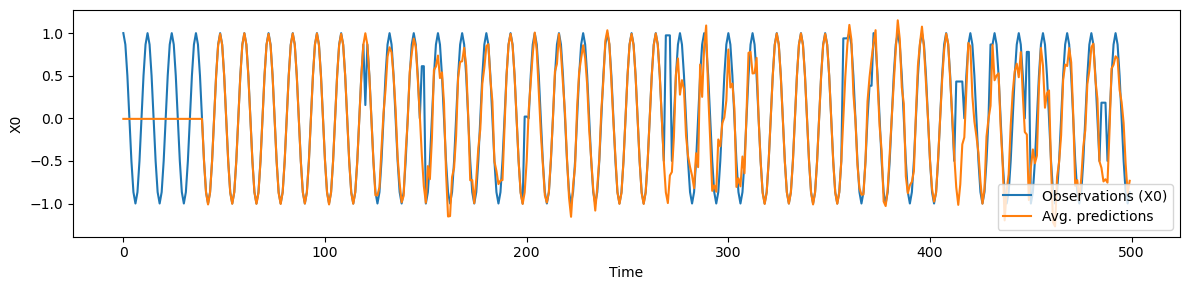

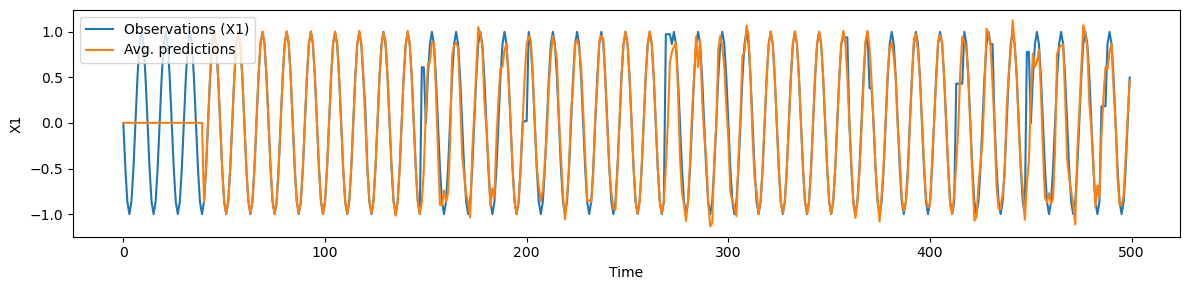

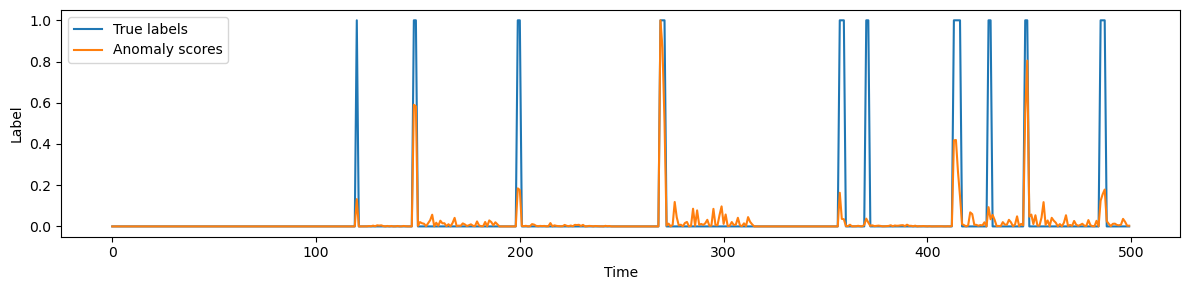

In [15]:
# Visualization
for i in range(X_attack.shape[1]):
    plt.figure(figsize=(12, 3))
    plt.plot(X_attack[:, i], label=f'Observations (X{i})')
    plt.plot(X_pred[:, i], label='Avg. predictions')
    plt.xlabel('Time')
    plt.ylabel(f'X{i}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_attack, label='True labels')
plt.plot(anomaly_scores / anomaly_scores.max(), label='Anomaly scores')
plt.xlabel('Time')
plt.ylabel('Label')
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
from scripts.utils import anomalybert_quality_metrics

anomalybert_quality_metrics(y_attack[context_len:], anomaly_scores[context_len:])

Best F1-score without point adjustment
anomaly rate: 0.038 | precision: 1.00000 | recall: 0.75000 | F1-score: 0.85714 | ROC AUC: 0.98614

Best F1-score with point adjustment
anomaly rate: 0.035 | precision: 1.00000 | recall: 0.83333 | F1-score: 0.90909 | ROC AUC: 0.98614



(np.float64(1.0),
 np.float64(0.8333333333333334),
 np.float64(0.9090909090909091),
 0.9861429663608563)